In [31]:
import pickle
import os

with open(r".\BL_Snipets\Stanford\Stanford_Nova_Regular_Ref_100.pkl", "rb") as f:
    data = pickle.load(f)
with open(r".\BL_Snipets\Stanford\Stanford_Nova_Regular_Ref_101.pkl", "rb") as f:
    data2 = pickle.load(f)

In [53]:
for key, value in data.items():
    print(f"{key}: {str(value)[:100]}")
for key, value in data2.items():
    print(f"{key}: {str(value)[:100]}")


cell_id: Stanford_Nova_Regular_Ref_100
cycle_data: [{'cycle_number': 1, 'current_in_A': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.
form_factor: pouch
anode_material: graphite
cathode_material: LiNi0.5Mn0.3Co0.2O2
electrolyte_material: None
nominal_capacity_in_Ah: 0.24
depth_of_charge: 1.0
depth_of_discharge: 1.0
already_spent_cycles: 0
max_voltage_limit_in_V: 4.4
min_voltage_limit_in_V: 3
max_current_limit_in_A: None
min_current_limit_in_A: None
reference: None
description: None
charge_protocol: [{'rate_in_C': 1.0, 'current_in_A': None, 'voltage_in_V': None, 'power_in_W': None, 'start_voltage_i
discharge_protocol: [{'rate_in_C': 0.75, 'current_in_A': None, 'voltage_in_V': None, 'power_in_W': None, 'start_voltage_
SOC_interval: [0, 1]
cell_id: Stanford_Nova_Regular_Ref_101
cycle_data: [{'cycle_number': 1, 'current_in_A': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.
form_factor: pouch
anode_material: graphite
cathode_material: LiNi0.5Mn0.3Co0.2O2
e

In [29]:
type(data["discharge_protocol"][0])
len(data["cycle_data"][0])
print([x for x in data["cycle_data"][0].keys()])
len(data["cycle_data"])

['cycle_number', 'current_in_A', 'voltage_in_V', 'charge_capacity_in_Ah', 'discharge_capacity_in_Ah', 'time_in_s', 'temperature_in_C', 'internal_resistance_in_ohm']


785

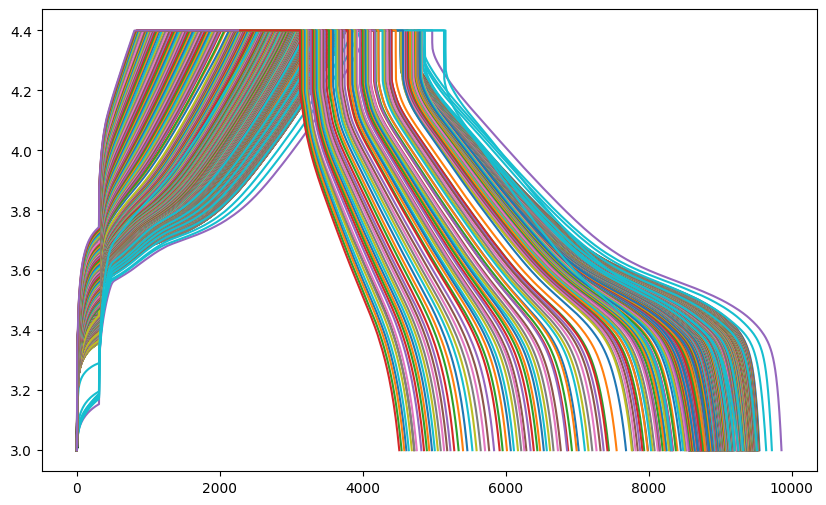

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for i in [x for x in range(len(data["cycle_data"]))]:
    rel_time =  [x - data["cycle_data"][i]["time_in_s"][0] for x in data["cycle_data"][i]["time_in_s"]]
    plt.plot(rel_time, data["cycle_data"][i]["voltage_in_V"], label=f"Cycle {i}")

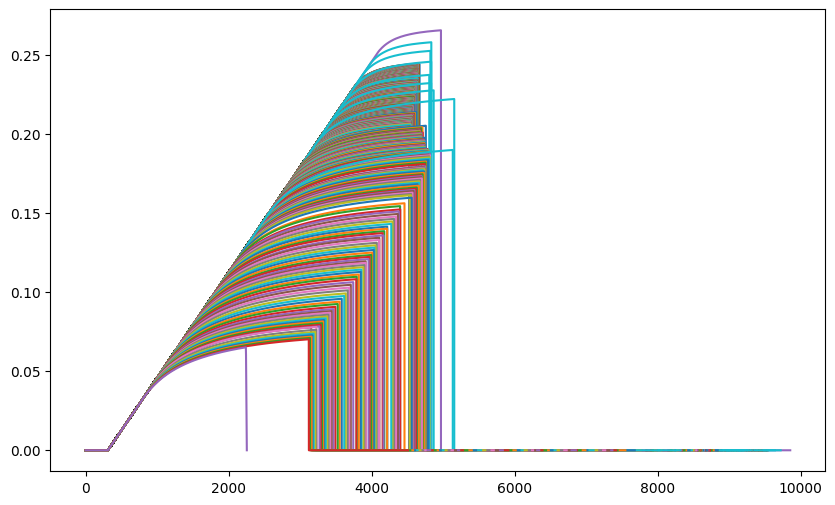

In [42]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for i in [x for x in range(len(data["cycle_data"]))]:
    rel_time =  [x - data["cycle_data"][i]["time_in_s"][0] for x in data["cycle_data"][i]["time_in_s"]]
    plt.plot(rel_time, data["cycle_data"][i]["charge_capacity_in_Ah"], label=f"Cycle {i}")

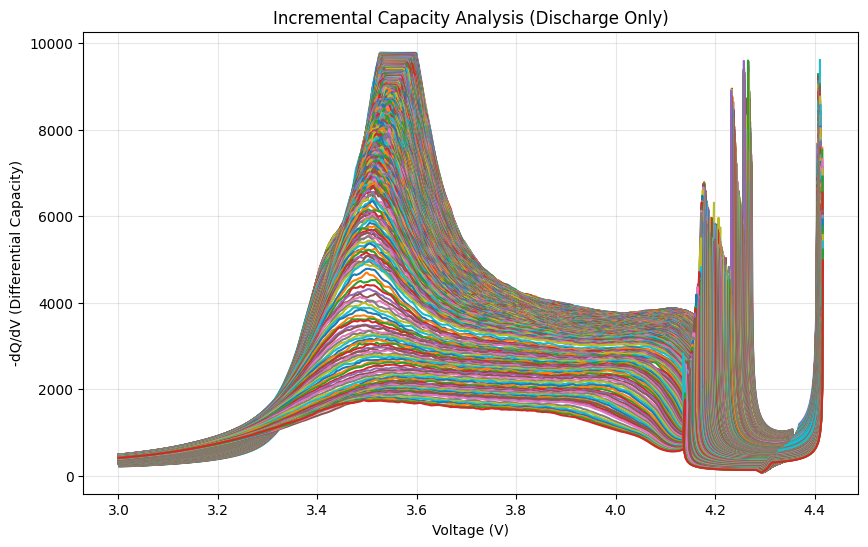

In [50]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter

plt.figure(figsize=(10, 6))

for i, cycle in enumerate(data["cycle_data"]):
    # Convert to numpy arrays
    t = np.array(cycle["time_in_s"])
    v = np.array(cycle["voltage_in_V"])
    
    # --- 1. Isolate the Discharge Phase ---
    # Instead of a complex 5-sample check, we can smooth the data 
    # and find the global maximum (peak charge). Everything after is discharge.
    
    # Smooth first to ensure the 'argmax' isn't just a noise spike
    # window_length must be odd. 
    window = max(11, len(v) // 40)
    if window % 2 == 0: window += 1
    v_smooth_all = savgol_filter(v, window, 3)
    
    # Find the index of the peak voltage
    peak_idx = np.argmax(v_smooth_all)
    
    # Slice arrays to keep only the discharge portion (Peak -> End)
    v_discharge = v_smooth_all[peak_idx:]
    t_discharge = t[peak_idx:]
    
    # --- 2. Calculate Derivatives ---
    dt = np.gradient(t_discharge)
    dv = np.gradient(v_discharge)
    
    # --- 3. Filter "Flat" Regions (The 1e6 Spike Fix) ---
    # We only want regions where voltage is actually dropping.
    # If dv is near 0 (rest) or positive (noise/recovery), we ignore it.
    
    # Threshold: Voltage must drop by at least 100uV per step (adjust as needed)
    valid_mask = dv < -5e-4
    
    # Apply calculation only on valid points
    # Note: We use -dt/dv to make the peaks positive
    dq_dv = -dt[valid_mask] / dv[valid_mask]
    voltage_axis = v_discharge[valid_mask]

    plt.plot(voltage_axis, dq_dv, label=f"Cycle {i}")

# --- Formatting ---
plt.xlabel("Voltage (V)")
plt.ylabel("-dQ/dV (Differential Capacity)")
plt.title("Incremental Capacity Analysis (Discharge Only)")
plt.grid(True, alpha=0.3)

# Important: Set a Y-limit to hide any remaining edge-case spikes
# You might need to adjust '2000' based on your actual time units
# plt.ylim(0, 2000) 

plt.show()

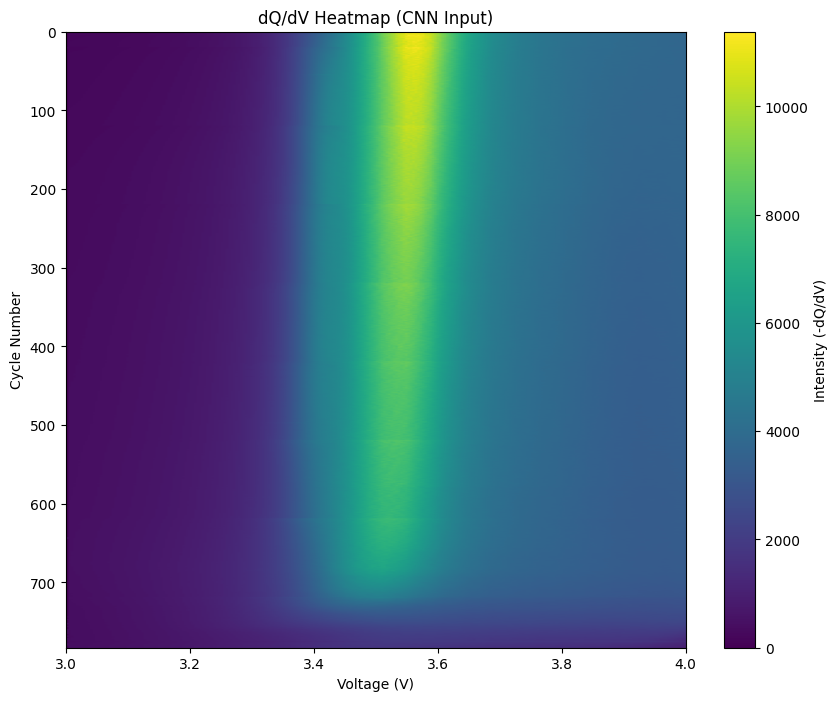

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d

# --- Configuration ---
V_MIN, V_MAX = 3.0, 4  # Adjust to your battery's voltage range
N_BINS = 256             # Number of voltage points (X-axis resolution)
v_grid = np.linspace(V_MIN, V_MAX, N_BINS)

dqdv_matrix = []
cycle_indices = []

for i, cycle in enumerate(data["cycle_data"]):
    # 1. Extract and Smooth Data
    t = np.array(cycle["time_in_s"])
    v = np.array(cycle["voltage_in_V"])
    
    # Smooth voltage to handle noise
    window = max(11, len(v) // 50)
    if window % 2 == 0: window += 1
    
    try:
        v_smooth = savgol_filter(v, window, 3)
    except ValueError:
        continue # Skip cycles that are too short

    # 2. Isolate Discharge
    peak_idx = np.argmax(v_smooth)
    v_dis = v_smooth[peak_idx:]
    t_dis = t[peak_idx:]
    
    # 3. Calculate dQ/dV
    dt = np.gradient(t_dis)
    dv = np.gradient(v_dis)
    
    # Filter flat/noisy regions (avoid division by zero)
    mask = dv < -1e-4 
    
    if np.sum(mask) < 10:
        continue # Skip bad cycles
        
    # Calculate -dt/dV (positive peaks)
    dq_dv = -dt[mask] / dv[mask]
    v_vals = v_dis[mask]
    
    # 4. Interpolate onto Fixed Grid (Critical for CNN Image)
    # Sort by voltage (discharge voltage decreases, so we need to sort ascending for interp)
    sorted_idx = np.argsort(v_vals)
    v_sorted = v_vals[sorted_idx]
    dq_dv_sorted = dq_dv[sorted_idx]
    
    # Remove duplicates
    unique_v, unique_idx = np.unique(v_sorted, return_index=True)
    unique_dqdv = dq_dv_sorted[unique_idx]
    
    # Create interpolator
    f = interp1d(unique_v, unique_dqdv, kind='linear', bounds_error=False, fill_value=0)
    dqdv_interp = f(v_grid)
    
    dqdv_matrix.append(dqdv_interp)
    cycle_indices.append(i)

# Convert to 2D Array (Height: Cycles, Width: Voltage)
dqdv_image = np.array(dqdv_matrix)

# --- Visualization ---
plt.figure(figsize=(10, 8))
# extent sets the axis labels to match the data range
plt.imshow(dqdv_image, aspect='auto', cmap='viridis', 
           extent=[V_MIN, V_MAX, max(cycle_indices), min(cycle_indices)])

plt.colorbar(label='Intensity (-dQ/dV)')
plt.xlabel('Voltage (V)')
plt.ylabel('Cycle Number')
plt.title('dQ/dV Heatmap (CNN Input)')
plt.show()

# If you need to save the raw matrix for your CNN:
# np.save('dqdv_image.npy', dqdv_image)

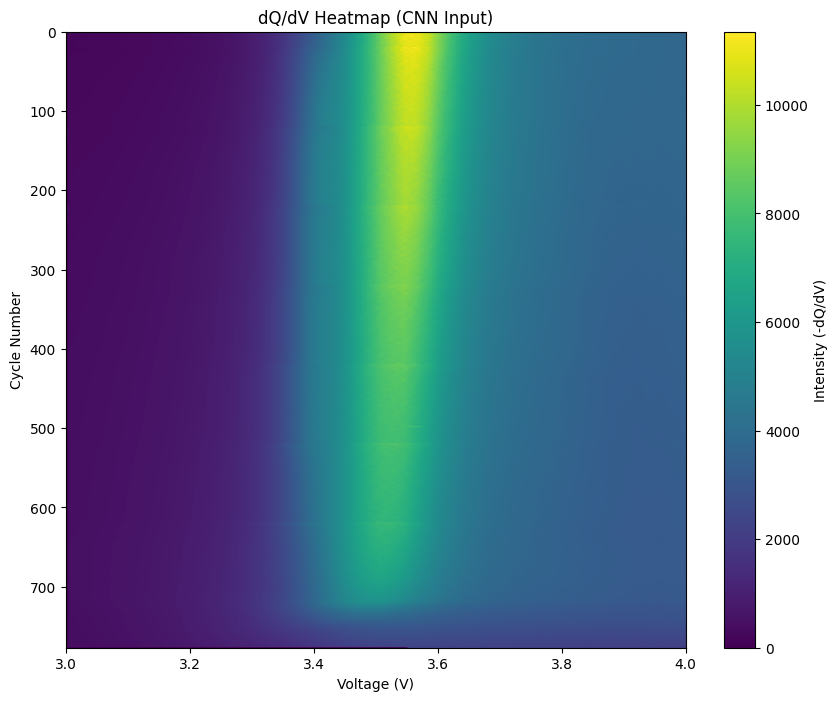

In [54]:

# --- Configuration ---
V_MIN, V_MAX = 3.0, 4  # Adjust to your battery's voltage range
N_BINS = 256             # Number of voltage points (X-axis resolution)
v_grid = np.linspace(V_MIN, V_MAX, N_BINS)

dqdv_matrix = []
cycle_indices = []

for i, cycle in enumerate(data2["cycle_data"]):
    # 1. Extract and Smooth Data
    t = np.array(cycle["time_in_s"])
    v = np.array(cycle["voltage_in_V"])
    
    # Smooth voltage to handle noise
    window = max(11, len(v) // 50)
    if window % 2 == 0: window += 1
    
    try:
        v_smooth = savgol_filter(v, window, 3)
    except ValueError:
        continue # Skip cycles that are too short

    # 2. Isolate Discharge
    peak_idx = np.argmax(v_smooth)
    v_dis = v_smooth[peak_idx:]
    t_dis = t[peak_idx:]
    
    # 3. Calculate dQ/dV
    dt = np.gradient(t_dis)
    dv = np.gradient(v_dis)
    
    # Filter flat/noisy regions (avoid division by zero)
    mask = dv < -1e-4 
    
    if np.sum(mask) < 10:
        continue # Skip bad cycles
        
    # Calculate -dt/dV (positive peaks)
    dq_dv = -dt[mask] / dv[mask]
    v_vals = v_dis[mask]
    
    # 4. Interpolate onto Fixed Grid (Critical for CNN Image)
    # Sort by voltage (discharge voltage decreases, so we need to sort ascending for interp)
    sorted_idx = np.argsort(v_vals)
    v_sorted = v_vals[sorted_idx]
    dq_dv_sorted = dq_dv[sorted_idx]
    
    # Remove duplicates
    unique_v, unique_idx = np.unique(v_sorted, return_index=True)
    unique_dqdv = dq_dv_sorted[unique_idx]
    
    # Create interpolator
    f = interp1d(unique_v, unique_dqdv, kind='linear', bounds_error=False, fill_value=0)
    dqdv_interp = f(v_grid)
    
    dqdv_matrix.append(dqdv_interp)
    cycle_indices.append(i)

# Convert to 2D Array (Height: Cycles, Width: Voltage)
dqdv_image = np.array(dqdv_matrix)

# --- Visualization ---
plt.figure(figsize=(10, 8))
# extent sets the axis labels to match the data range
plt.imshow(dqdv_image, aspect='auto', cmap='viridis', 
           extent=[V_MIN, V_MAX, max(cycle_indices), min(cycle_indices)])

plt.colorbar(label='Intensity (-dQ/dV)')
plt.xlabel('Voltage (V)')
plt.ylabel('Cycle Number')
plt.title('dQ/dV Heatmap (CNN Input)')
plt.show()

# If you need to save the raw matrix for your CNN:
# np.save('dqdv_image.npy', dqdv_image)